In [1]:
import pickle
from multiprocessing import Pool
from glob import glob
from collections import Counter
from astropy.utils.data import get_pkg_data_filename
import pyink as pu

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
from tqdm import tqdm as tqdm
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from reproject import reproject_interp

In [3]:
emu = glob('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits')
print(len(emu))
print(emu[0])

1
image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits


In [4]:
tab = Table.read('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits').to_pandas()
tab.head(5) # there are 35

,BEAM,NAME,RA,DEC,BMAJ,BMIN,BPA
0,0,b'./image.i.EMU_2115-6',-46.451871,-62.170819,12.190899,10.688850,88.638426
1,1,b'./image.i.EMU_2115-6',-44.525079,-62.230139,12.169599,10.691446,88.309974
2,2,b'./image.i.EMU_2115-6',-42.593279,-62.263139,12.506018,10.809036,-86.132462
3,3,b'./image.i.EMU_2115-6',-40.659321,-62.269739,12.109623,10.679411,87.676195
4,4,b'./image.i.EMU_2115-6',-38.726079,-62.249939,12.458843,10.789674,-86.844433


In [38]:
filename = get_pkg_data_filename('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
wcs.wcs.specsys = 'TOPOCENT'
#np.nanstd(np.squeeze(hdu.data)) #ignore all NaN 

In [2]:
def radio_preprocessing(data, lower = 3):
    noise = pu.rms_estimate(data.flatten(), mode='mad', clip_rounds=2)

    img_scale = np.zeros_like(data)
    for i, mask in enumerate(pu.island_segmentation(data, 3*noise)):
        if np.sum(mask) <= 5:
            continue
        img_scale[mask] = pu.minmax(np.log10(data[mask]))
    return img_scale.astype(np.float32)

### RAW RADIO DATA

In [7]:
hdu.data

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)

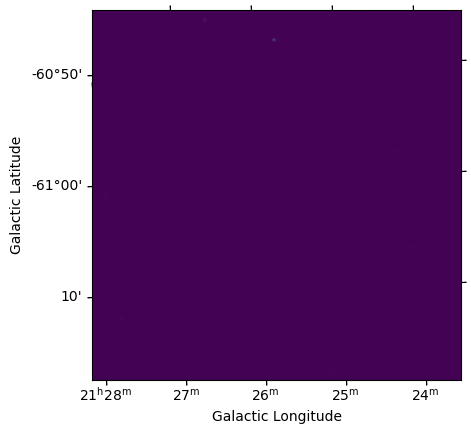

In [143]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([5000, 6000, 5000, 6000]) #example of coordinate
plt.imshow(np.squeeze(hdu.data), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
#hough circle only run on jpeg
#pybdsf runs on fits file

## WITH PREPROCESSED RADIO

In [12]:
#interested in `complex` objects
#preprocessed_radio = radio_preprocessing(hdu.data, lower = 3)

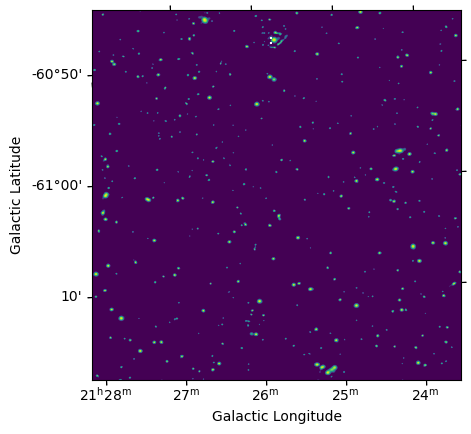

In [27]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([5000, 6000, 5000, 6000])
plt.imshow(np.squeeze(preprocessed_radio), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
#hough circle only run on jpeg
#pybdsf runs on fits file

Export the preprocessed_radio into a separated file called `preprocessed_radio.txt`

In [ ]:
#import pickle
#file = open('preprocessed_radio.txt', 'wb')
#pickle.dump(preprocessed_radio, file)
#file.close()

file = open('preprocessed_radio.txt', 'rb')
preprocessed_data = pickle.load(file)
preprocessed_data #whenever the file is corrupted, just load this data into the preprocessed_radio data
preprocessed_radio = preprocessed_data

embed the preprocessed data into the original glob

In [28]:
preprocessed_hdu = hdu
preprocessed_hdu.data = preprocessed_radio
preprocessed_wcs = WCS(preprocessed_hdu.header)
preprocessed_wcs.wcs.specsys = 'TOPOCENT'

Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


---

## TEST ON GIVEN ORCS CIRCLE from this paper
https://academic.oup.com/mnras/article/513/1/1300/6553851?login=false

from this research site:
https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.1300N/graphics

In [22]:
from astropy.io import fits
 
with fits.open('orc1-askap.fits') as hdu_test:
    askap_orc_data = hdu_test[0].data
    askap_header = hdu_test[0].header
    askap_wcs = WCS(askap_header)
    hdu_test.info()

Filename: orc1-askap.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (182, 165)   float32   


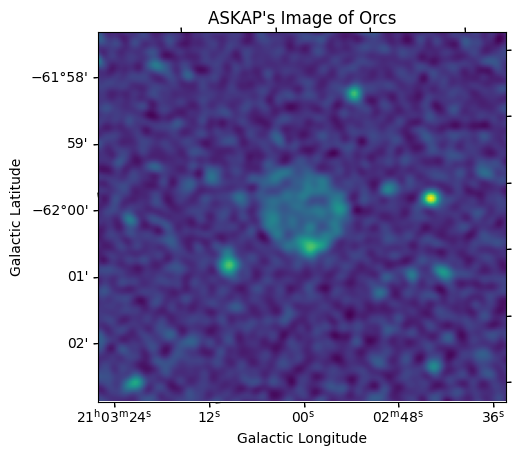

In [23]:
plt.subplot(projection=askap_wcs, slices = ('x','y',0,0))
plt.imshow(np.squeeze(askap_orc_data), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.title("ASKAP's Image of Orcs")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
#hough circle only run on jpeg
#pybdsf runs on fits file

In [5]:
def radio_preprocessing(data, lower = 3):
    noise = pu.rms_estimate(data.flatten(), mode='mad', clip_rounds=2)

    img_scale = np.zeros_like(data)
    for i, mask in enumerate(pu.island_segmentation(data, 3*noise)):
        if np.sum(mask) <= 5:
            continue
        img_scale[mask] = pu.minmax(np.log10(data[mask]))
    return img_scale.astype(np.float32)

In [6]:
#interested in `complex` objects
preprocessed_radio_ORCS = radio_preprocessing(askap_orc_data, lower = 3)

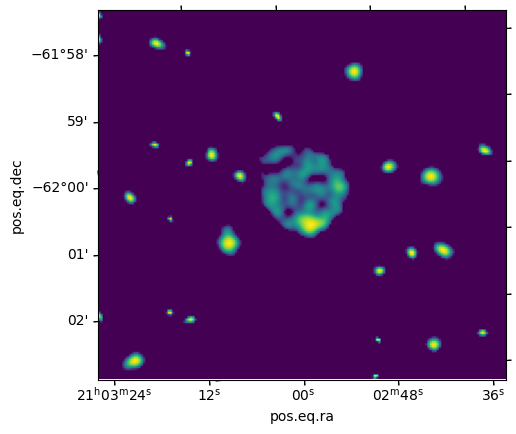

In [42]:
plt.subplot(projection=askap_wcs, slices = ('x','y',0,0))
plt.imshow(np.squeeze(preprocessed_radio_ORCS), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.title("ASKAP's Image of Orcs")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
#plt.savefig('ASKAP ORCS')
plt.show()#hough circle only run on jpeg
#pybdsf runs on fits file

In [45]:
#save the current ORCS file
hdu_test2 = hdu_test
hdu_test2[0].data = preprocessed_radio_ORCS
#hdu_test2.writeto('preprocessed_radio_ORCS.fits')

---

# Classification task

In [13]:
import numpy as np
import cv2 as cv
#Cant do openCV on big data server

In [47]:
img = cv.imread('ASKAP ORCS.png')
cv.imshow('Circle', img)
cv.waitKey(0)
cv.destroyAllWindows()

REFERENCE:

https://academic.oup.com/mnras/article/513/1/1300/6553851?login=false